# **RandomForest**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib import style
import seaborn as sns
import warnings
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, f1_score, precision_score, recall_score, roc_curve, auc
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score, train_test_split, RepeatedKFold, GridSearchCV
import multiprocessing
import joblib
from sklearn.ensemble import RandomForestClassifier
import preprocessing as pp
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
warnings.filterwarnings('ignore')

# Obtenemos los dataframes con los que trabajaremos

In [2]:
X, y = pp.get_X_y_from_dataset()

Hay un problema... la variable target "llovieron_hamburguesas_al_dia_siguiente" contiene NaNs (~2600). Esto es un problema a la hora de separar en train-valdev-holdout usando train_test_split si queremos preservar la proporción entre las clases del target en la partición (es decir, pasandole a esa función stratify=y). Como test-holdout nunca debe ver los datos de train o valdev, no deberíamos rellenar dichos NaNs usando datos de otras instancias (si no habría data leaks). Por ende, decidimos completar estos NaNs con la clase mayoritaria por lejos, el "no". 

In [3]:
y = pp.fill_nan_with_simple_imputer(y, ["llovieron_hamburguesas_al_dia_siguiente"], "most_frequent")

También no necesitamos la columna de id.

In [4]:
pp.drop_features(y, ['id'])

## Separamos en train y test-holdout
Test-holdout lo usaremos como métrica del mejor de los 5 modelos, para tener una idea antes que salga a producción. Tomaremos un 10% para el holdout, y hacemos que sea stratificado, de forma que divida el train y holdout teniendo en cuenta la proporción de la variable target. Notar que usamos el mismo RANDOM_STATE para todos los train_test_splits de los modelos para poder reproducir las mismas condiciones, entrenando y evaluando sobre las mismas particiones.

In [5]:
X_train, X_holdout, y_train, y_holdout = train_test_split(
    X, y, random_state=pp.RANDOM_STATE, test_size=0.1, stratify=y
)

# Preprocesamiento y Feature Engineering

A diferencia de las implementaciones de SKLearn, el XGBoost de esta librería no necesita tener una variable target numérica. Por eso no la encodeamos. Tampoco escalaremos/normalizaremos los datos, ya que en los árboles no lo necesitan.

# Corregimos los valores erráticos del dataset

El feature presión_atmosférica_tarde tiene algunos valores erráticos. Los eliminamos y dejamos temporalmente como NaN, de forma de rellenarlos (o no) a posteriori.

In [6]:
err_values_presion_atm = ['10.167.769.999.999.900', '1.009.555']

pp.convert_values_to_nan(X_train, 'presion_atmosferica_tarde', err_values_presion_atm)

Ahora sí, podemos convertir este feature de object a float16.

In [7]:
X_train['presion_atmosferica_tarde'] = X_train['presion_atmosferica_tarde'].astype('float32')

Y ahora corregimos los valores erráticos de la nubosidad_tarde y nubosidad_temprano:

In [8]:
err_values_nubosidad = [9.0]

pp.convert_values_to_nan(X_train, 'nubosidad_tarde', err_values_nubosidad)
pp.convert_values_to_nan(X_train, 'nubosidad_temprano', err_values_nubosidad)

Adicionalmente, convertimos de float a categórica-ordinal a los features de las nubosidades, ya que son valores discretos del 0 al 8.

In [9]:
X_train = pp.numerical_to_ordinal_categorical(X_train, ["nubosidad_tarde", "nubosidad_temprano"], [0,1,2,3,4,5,6,7,8])

## Descartemos features irrelevantes

Descartamos los features que no resultan relevantes para el modelo.

In [10]:
pp.drop_features(X_train, 
              ['dia',
             'humedad_temprano',
             'temp_min',
             'rafaga_viento_max_direccion',
             'velocidad_viendo_tarde',
             'velocidad_viendo_temprano',
             'rafaga_viento_max_velocidad'
            ])

## Aplicamos One Hot encoding a las variables categóricas no ordinales

In [11]:
X_train = pp.one_hot_encode(X_train, ['direccion_viento_tarde','direccion_viento_temprano', 'llovieron_hamburguesas_hoy'])

Adicionalmente, realizamos One Hot a 'Barrio'

In [12]:
X_train = pp.one_hot_encode(X_train, ['barrio'])

## Eliminemos los valores NaN completando con el mas frequente

Realizamos este paso para tener el dataset lo mas completo posible y así poder trabajar con mas datos

In [13]:
X_train = pp.fill_nan_with_simple_imputer(X_train, X_train.columns, "most_frequent")

## Hacemos Reducción Dimensional: PCA
La idea es condensar la información de todos los features que generó el one hot encoding de los barrios en unos pocos features que expliquen la mayor parte de la varianza. Por lo que investigamos, es algo común hacer one hot de variables categóricas de media-alta cardinalidad y después aplicar PCA. 

Primero, obtenemos una lista de los features relacionados a los barrios.

In [14]:
features_barrios = list(filter(lambda c: "barrio" in c, X_train.columns))

In [15]:
name_final_features = ["infobarrio1","infobarrio2","infobarrio3","infobarrio4","infobarrio5",
                      "infobarrio6","infobarrio7","infobarrio8","infobarrio9","infobarrio10"]

In [16]:
X_train, var_explained = pp.reduce_dimension_of_features(
    X_train,
    n_final_features=10,
    features_to_reduce=features_barrios,
    feature_names=name_final_features
)
X_train = pp.convert_features(X_train, name_final_features, "float32")
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104731 entries, 0 to 104730
Data columns (total 54 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   horas_de_sol                             104731 non-null  float32
 1   humedad_tarde                            104731 non-null  float32
 2   id                                       104731 non-null  int32  
 3   mm_evaporados_agua                       104731 non-null  float32
 4   mm_lluvia_dia                            104731 non-null  float32
 5   nubosidad_tarde                          104731 non-null  float64
 6   nubosidad_temprano                       104731 non-null  float64
 7   presion_atmosferica_tarde                104731 non-null  float32
 8   presion_atmosferica_temprano             104731 non-null  float32
 9   temp_max                                 104731 non-null  float32
 10  temperatura_tarde               

In [17]:
var_explained.cumsum()

array([0.02339446, 0.04643227, 0.06937441, 0.09182037, 0.11421328,
       0.13643545, 0.15852618, 0.18053091, 0.20238697, 0.22418933])

## Separamos en train y val-dev antes de hacer GridSearch

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_train,
                                                    y_train, 
                                                    test_size = 0.3, 
                                                    random_state = pp.RANDOM_STATE, 
                                                    stratify=y_train)

# Buscamos los mejores hiperparametros

Utilizamos GS para iterar entre todos los parametros y CV de 5 folds para obtener el mejor resultado por sobre varios testeos.

Determinamos 
#### n_estimators -> [350, 150, 500]
#### max_depth -> [None, 10 ,30]
#### min_samples_split -> [15, 20, 30, 60]

In [19]:
%%script false --no-raise-error # Para no ejecutar este bloque
params = {'n_estimators': [350, 150, 500], 'max_depth': [None, 10 ,30], 'min_samples_split': [15, 20, 30, 60]}
clf = RandomForestClassifier()

gscv = GridSearchCV(
    clf, params, scoring='f1_micro', n_jobs=-1, cv=5, return_train_score=True
).fit(X_train, y_train)

gscv.best_estimator_

# Cargamos el modelo ya con los mejores hiperparámetros y lo entrenamos
Ya corrimos el GridSearch. Esta vez, al mejor modelo no lo guardamos en un .pickle como a los otros modelos, ya que pesaba mucho (son 500 árboles...). Por eso, decidimos simplemente construirlo a mano. Luego, entrenaremos este modelo pero en el X_train completo, para luego evaluarlo en X_test.

In [20]:
clf = RandomForestClassifier(max_depth=30, min_samples_split=15, n_estimators=500)
clf

RandomForestClassifier(max_depth=30, min_samples_split=15, n_estimators=500)

In [21]:
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=30, min_samples_split=15, n_estimators=500)

# Evaluamos en val-dev y medimos la performance

In [22]:
clf_pred = clf.predict(X_test)

### F1, Precision, Recall, Accuracy

In [23]:
f1_score(y_test, clf_pred, average='weighted')

0.8402432346918742

In [24]:
precision_score(y_test, clf_pred,average='weighted')

0.8442660855571233

In [25]:
recall_score(y_test, clf_pred, average='weighted')

0.8530553787396563

In [26]:
accuracy_score(y_test, clf_pred)

0.8530553787396563

### Confusion Matrix

In [27]:
clf_pred_proba = clf.predict_proba(X_test)
clf_pred_proba_pos = clf_pred_proba[:,1] 

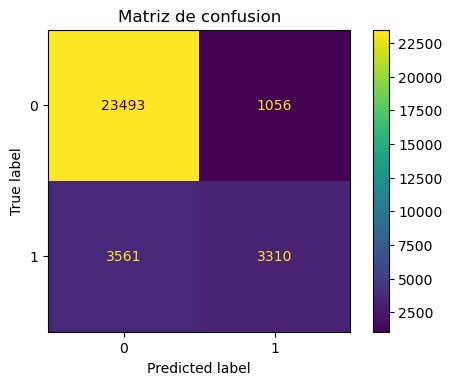

In [28]:
cm = confusion_matrix(y_test, clf_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
fig, ax = plt.subplots(dpi=100)
plt.title("Matriz de confusion")
disp.plot(ax=ax)

### AUC-ROC

In [29]:
def plot_roc(_fpr, _tpr, x):

    roc_auc = auc(_fpr, _tpr)

    plt.figure(figsize=(12, 8))
    plt.plot(
        _fpr, _tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.5f})'
    )
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

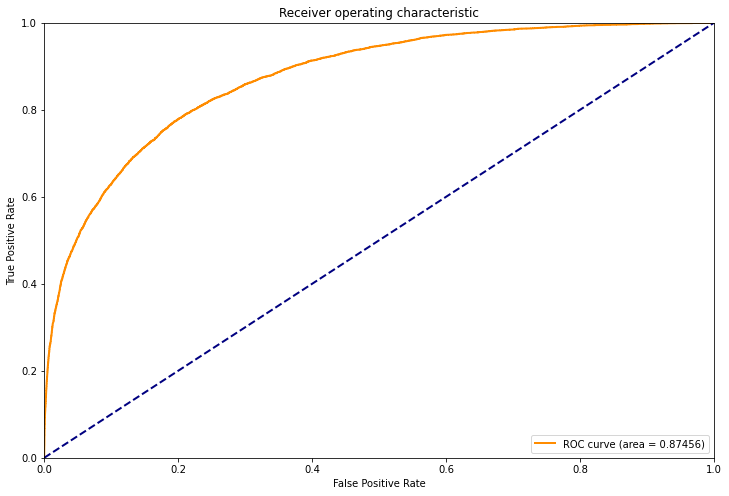

AUC_ROC:  0.8745638203009093


In [30]:
y_binary = pp.one_hot_encode(y_test, ['llovieron_hamburguesas_al_dia_siguiente'])
pp.drop_features(y_binary, ['llovieron_hamburguesas_al_dia_siguiente_nan'])
fpr, tpr, thresholds = roc_curve(y_binary, clf_pred_proba_pos)
plot_roc(fpr, tpr, thresholds)
print("AUC_ROC: ", roc_auc_score(y_binary, clf_pred_proba_pos))

# Predicción sobre los datos privados de Flint

Primero, hacemos el preprocesamiento de los datos, utilizando el mismo feature engineering que realizamos antes, para que el modelo pueda entender los datos que le pasamos. Luego, predecimos usando el modelo ya entrenado y finalmente guardamos los resultados.

In [31]:
X_private = pp.get_X_private_features()

In [32]:
def preprocess_X_for_RandomForest(X):
    X['presion_atmosferica_tarde'] = X['presion_atmosferica_tarde'].astype('float32')
    
    X = pp.numerical_to_ordinal_categorical(X, 
                                            ["nubosidad_tarde", "nubosidad_temprano"], 
                                            [0,1,2,3,4,5,6,7,8])
    pp.drop_features(X, 
              ['dia',
             'humedad_temprano',
             'temp_min',
             'rafaga_viento_max_direccion',
             'velocidad_viendo_tarde',
             'velocidad_viendo_temprano',
             'rafaga_viento_max_velocidad'
    ])
        
    X = pp.one_hot_encode(X, ['direccion_viento_tarde','direccion_viento_temprano', 'llovieron_hamburguesas_hoy'])
    X = pp.one_hot_encode(X, ['barrio'])
    
    X = pp.fill_nan_with_simple_imputer(X, X.columns, "most_frequent")
    
    features_barrios = list(filter(lambda c: "barrio" in c, X.columns))
    name_final_features = ["infobarrio1","infobarrio2","infobarrio3","infobarrio4","infobarrio5",
                      "infobarrio6","infobarrio7","infobarrio8","infobarrio9","infobarrio10"]
    X, var_explained = pp.reduce_dimension_of_features(
        X,
        n_final_features=10,
        features_to_reduce=features_barrios,
        feature_names=name_final_features
    )
    X = pp.convert_features(X, name_final_features, "float32")
    
    return X

In [33]:
X_private = preprocess_X_for_RandomForest(X_private)

In [34]:
rf_priv_feat_pred = clf.predict(X_private)

In [35]:
predictions = X_private.loc[:,['id']]
predictions["llovieron_hamburguesas_al_dia_siguiente"] = rf_priv_feat_pred
predictions = predictions.set_index('id')
predictions.head()

,llovieron_hamburguesas_al_dia_siguiente
id,
116706,no
58831,no
31981,no
2533,no
7270,si


In [36]:
predictions.to_csv('predicciones/RandomForest.csv')